In [5]:
from jitcdde import jitcdde, y, t, jitcdde_input, input
from parameters_estimate import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from variables import *
from chspy import CubicHermiteSpline
from scipy.interpolate import CubicSpline

In [6]:
# heat transfer functions
def dT_convective(a: list, b: y, hA_mcp: list):
    '''
    Energy from convective heat transfer
    a: from node(s) (state variable(s) y(i))
    b: to node (state variable y(i))
    hA_mcp: ratio of [convective heat transfer coefficient(s) * wetted area(s) (MW/C)]
            to [product of node mass (kg) and node specific heat capcity (MJ)/(kg*k)]
    f: fractional adjustments
    '''
    tot = 0.0
    for i in range(len(a)):
        tot += hA_mcp[i]*(a[i]-b)
    return tot

def dT_bulkFlow(W: float, m: float, a: y, b: y, dumped: bool = False):
    '''
    Energy from bulk flow
    W: mass flow rate (kg/s)
    m: node mass (kg)
    a: Q from node (state variable y(i))
    b: Q to node (state variable y(i))
    dumped: if 'from node' is a constant (indicates dumping instead of 
            recirculation), this needs to be set to true
    '''
    if (dumped):
        return (a)*W/m
    else: 
        return (a-b)*W/m

def dT_internal(k: float, P: float, mcp: float, n: y):
    '''
    Energy from fission
    k: fraction of power generation in node 
    P: nominal power (MW)
    mcp: product of node mass (kg) and node specific heat capacity (MJ/(kg*K))
    n: fractional neutron density 
    '''
    return k*P*n/mcp


System Function

In [7]:
def run_simulation(params):

    # Unpack parameters
    a_f, a_g, a_c, inserted, beta_t = params

    # CORE
    # fuel nodes
    dc_f1 = dT_bulkFlow(W_f, m_f_c/2, (hx_fh1_f2(t-tau_hx_c_f)+hx_fh2_f2(t-tau_hx_c_f))/2,c_f1()) + dT_internal(k_f1, P, mcp_f_c, n()) + F*dT_convective([c_t1()],c_f1(),[hA_ft_c/mcp_f_c]) - arbitrary_removal*c_f1()
    dc_f2 = dT_bulkFlow(W_f, m_f_c/2, c_f1(), c_f2()) +                                             dT_internal(k_f1, P, mcp_f_c, n()) + dT_convective([c_t1()],c_f2(),[hA_ft_c/mcp_f_c]) - arbitrary_removal*c_f2()

    # tubes
    dc_t1= F*dT_convective([c_f1(),c_f2(),c_c1(),c_c2()],c_t1(),[hA_ft_c/mcp_t_c,hA_ft_c/mcp_t_c,hA_tc_c/mcp_t_c,hA_tc_c/mcp_t_c]) - arbitrary_removal*c_t1()

    # coolant 
    dc_c1 = dT_bulkFlow(W_c,m_c_c/2,(hx_ch1_c2(t-tau_hx_c_c)+hx_ch2_c2(t-tau_hx_c_c))/2,c_c1()) + F*dT_convective([c_t1(),c_m()],c_c1(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c]) - arbitrary_removal*c_c1()
    dc_c2 = dT_bulkFlow(W_c,m_c_c/2,c_c1(),c_c2()) +                                              F*dT_convective([c_t1(),c_m()],c_c2(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c]) - arbitrary_removal*c_c2()

    # moderator 
    dc_m =  dT_internal(k_m,P,mcp_m_c,n()) + F*dT_convective([c_c1(),c_c2()],c_m(),[hA_mc_c/mcp_m_c,hA_mc_c/mcp_m_c])

    # FUEL-HELIUM HX1
    dhx_fh1_f1 = dT_bulkFlow(W_f,m_f_hx,c_f2(t-tau_c_hx_f),hx_fh1_f1()) + F*dT_convective([hx_fh1_t1()],hx_fh1_f1(),[hA_ft_hx/mcp_f_hx]) 
    dhx_fh1_f2 = dT_bulkFlow(W_f,m_f_hx,hx_fh1_f1(),hx_fh1_f2()) +        F*dT_convective([hx_fh1_t1()],hx_fh1_f2(),[hA_ft_hx/mcp_f_hx]) 

    # Tubes 
    dhx_fh1_t1 = dT_convective([hx_fh1_f1(),hx_fh1_f2(),hx_fh1_h1(),hx_fh1_h2()],hx_fh1_t1(),[h/mcp_t_hx for h in [hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx]])

    # Helium
    dhx_fh1_h1 = dT_bulkFlow(W_h_fh,m_h_hxfh,hx_hwf2_h2(t-tau_h),hx_fh1_h1()) + F*dT_convective([hx_fh1_t1()],hx_fh1_h1(),[hA_ht_hx/mcp_h_hxfh])
    dhx_fh1_h2 = dT_bulkFlow(W_h_fh,m_h_hxfh,hx_fh1_h1(),hx_fh1_h2()) +         F*dT_convective([hx_fh1_t1()],hx_fh1_h2(),[hA_ht_hx/mcp_h_hxfh])

    # FUEL-HELIUM HX2 Fuel Nodes
    dhx_fh2_f1 = dT_bulkFlow(W_f,m_f_hx,c_f2(t-tau_c_hx_f), hx_fh2_f1()) + F*dT_convective([hx_fh2_t1()],hx_fh2_f1(),[hA_ft_hx/mcp_f_hx])
    dhx_fh2_f2 = dT_bulkFlow(W_f,m_f_hx,hx_fh2_f1(),hx_fh2_f2()) +         F*dT_convective([hx_fh2_t1()],hx_fh2_f2(),[hA_ft_hx/mcp_f_hx])

    # Tubes for FUEL-HELIUM HX2
    dhx_fh2_t1 = dT_convective([hx_fh2_f1(),hx_fh2_f2(),hx_fh2_h1(),hx_fh2_h2()],hx_fh2_t1(),[h/mcp_t_hx for h in [hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx]])

    # Helium for FUEL-HELIUM HX2
    dhx_fh2_h1 = dT_bulkFlow(W_h_fh,m_h_hxfh,hx_hwf1_h2(),hx_fh2_h1()) + F*dT_convective([hx_fh2_t1()],hx_fh2_h1(),[hA_ht_hx/mcp_h_hxfh])
    dhx_fh2_h2 = dT_bulkFlow(W_h_fh,m_h_hxfh,hx_fh2_h1(),hx_fh2_h2()) +  F*dT_convective([hx_fh2_t1()],hx_fh2_h2(),[hA_ht_hx/mcp_h_hxfh])

    # COOLANT-HELIUM HX1
    # Fuel Nodes
    dhx_ch1_c1 = dT_bulkFlow(W_c, m_c_hx, c_c2(t-tau_c_hx_f), hx_ch1_c1()) + F*dT_convective([hx_ch1_t1()], hx_ch1_c1(), [hA_ct_hx/mcp_c_hxch])
    dhx_ch1_c2 = dT_bulkFlow(W_c, m_c_hx, hx_ch1_c1(), hx_ch1_c2()) +        F*dT_convective([hx_ch1_t1()], hx_ch1_c2(), [hA_ct_hx/mcp_c_hxch])

    # Tubes
    dhx_ch1_t1 = F*dT_convective([hx_ch1_c1(),hx_ch1_c2(),hx_ch1_h1(),hx_ch1_h2()],hx_ch1_t1(),[h/mcp_t_hxch for h in [hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch]])

    # Helium
    dhx_ch1_h1 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_hwc1_h2(t-tau_h), hx_ch1_h1()) + F*dT_convective([hx_ch1_t1()], hx_ch1_h1(), [hA_th_hxch/mcp_h_hxch])
    dhx_ch1_h2 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_ch1_h1(), hx_ch1_h2()) +         F*dT_convective([hx_ch1_t1()], hx_ch1_h2(), [hA_th_hxch/mcp_h_hxch])

    # COOLANT-HELIUM HX2
    # Fuel Nodes
    dhx_ch2_c1 = dT_bulkFlow(W_c, m_c_hx, c_c2(t-tau_c_hx_f), hx_ch2_c1()) + F*dT_convective([hx_ch2_t1()], hx_ch2_c1(), [hA_ct_hx/mcp_c_hxch])
    dhx_ch2_c2 = dT_bulkFlow(W_c, m_c_hx, hx_ch2_c1(), hx_ch2_c2()) +        F*dT_convective([hx_ch2_t1()], hx_ch2_c2(), [hA_ct_hx/mcp_c_hxch])

    # Tubes
    dhx_ch2_t1 = dT_convective([hx_ch2_c1(),hx_ch2_c2(),hx_ch2_h1(),hx_ch2_h2()],hx_ch2_t1(),[h/mcp_t_hxch for h in [hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch]])

    # Helium
    dhx_ch2_h1 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_hwc2_h2(t-tau_h), hx_ch2_h1()) + F*dT_convective([hx_ch2_t1()], hx_ch2_h1(), [hA_th_hxch/mcp_h_hxch])
    dhx_ch2_h2 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_ch2_h1(), hx_ch2_h2()) +         F*dT_convective([hx_ch2_t1()], hx_ch2_h2(), [hA_th_hxch/mcp_h_hxch])

    # HELIUM-WATER HX1 (FUEL LOOP)
    # Helium
    T_hhwf_h1 = dT_bulkFlow(W_h_fh, m_h_hxhw/2, hx_fh1_h2(), hx_hwf1_h1()) +  F*dT_convective([hx_hwf1_t1()], hx_hwf1_h1(), [hA_ht_hxhw/mcp_h_hxhw])
    T_hhwf_h2 = dT_bulkFlow(W_h_fh, m_h_hxhw/2, hx_hwf1_h1(), hx_hwf1_h2()) + F*dT_convective([hx_hwf1_t1()], hx_hwf1_h2(), [hA_ht_hxhw/mcp_h_hxhw])

    # Tubes
    T_hhwf_t1 = F*dT_convective([hx_hwf1_h1(),hx_hwf1_h2(),hx_hwf1_w1(),hx_hwf1_w2()],hx_hwf1_t1(),[h/mcp_t_hxhw for h in [hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw]])

    # Water
    T_hhwf_w1 = dT_bulkFlow(W_hhwf_w, m_w/2, T0_hhwf_w1-hx_hwf1_w1(), hx_hwf1_w1(),dumped=True) + F*dT_convective([hx_hwf1_t1()], hx_hwf1_w1(), [hA_tw_hxhw/mcp_w])
    T_hhwf_w2 = dT_bulkFlow(W_hhwf_w, m_w/2, hx_hwf1_w1(), hx_hwf1_w2()) +                        F*dT_convective([hx_hwf1_t1()], hx_hwf1_w2(), [hA_tw_hxhw/mcp_w])

    # HELIUM-WATER HX2 (FUEL LOOP)
    # Helium
    T_hhwf2_h1 = dT_bulkFlow(W_h_fh, m_h_hxhw/2, hx_fh2_h2(), hx_hwf2_h1()) +  F*dT_convective([hx_hwf2_t1()], hx_hwf2_h1(), [hA_ht_hxhw/mcp_h_hxhw])
    T_hhwf2_h2 = dT_bulkFlow(W_h_fh, m_h_hxhw/2, hx_hwf2_h1(), hx_hwf2_h2()) + F*dT_convective([hx_hwf2_t1()], hx_hwf2_h2(), [hA_ht_hxhw/mcp_h_hxhw])

    # Tubes
    T_hhwf2_t1 = F*dT_convective([hx_hwf2_h1(),hx_hwf2_h2(),hx_hwf2_w1(),hx_hwf2_w2()],hx_hwf2_t1(),[h/mcp_t_hxhw for h in [hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw]])

    # Water
    T_hhwf2_w1 = dT_bulkFlow(W_hhwf_w, m_w/2, T0_hhwf_w1-hx_hwf2_w1(), hx_hwf2_w1(),dumped=True) + F*dT_convective([hx_hwf2_t1()], hx_hwf2_w1(), [hA_tw_hxhw/mcp_w])
    T_hhwf2_w2 = dT_bulkFlow(W_hhwf_w, m_w/2, hx_hwf2_w1(), hx_hwf2_w2()) +                        F*dT_convective([hx_hwf2_t1()], hx_hwf2_w2(), [hA_tw_hxhw/mcp_w])

    # HELIUM-WATER HX1 (COOLANT LOOP)
    # Helium
    T_hhwc_h1 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_ch1_h2(), hx_hwc1_h1()) + F*dT_convective([hx_hwc1_t1()], hx_hwc1_h1(), [hA_ht_hxhwc/mcp_h_hxhwc])
    T_hhwc_h2 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_hwc1_h1(), hx_hwc1_h2()) + F*dT_convective([hx_hwc1_t1()], hx_hwc1_h2(), [hA_ht_hxhwc/mcp_h_hxhwc])

    # Tubes
    T_hhwc_t1 = F*dT_convective([hx_hwc1_h1(),hx_hwc1_h2(),hx_hwc1_w1(),hx_hwc1_w2()],hx_hwc1_t1(),[h/mcp_t_hxhwc for h in [hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc]])

    # Water
    T_hhwc_w1 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, T0_hhwf_w1-hx_hwc1_w1(), hx_hwc1_w1(), dumped=True) + F*dT_convective([hx_hwc1_t1()], hx_hwc1_w1(), [hA_tw_hxhwc/mcp_w_hxhwc])
    T_hhwc_w2 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, hx_hwc1_w1(), hx_hwc1_w2()) + F*dT_convective([hx_hwc1_t1()], hx_hwc1_w2(), [hA_tw_hxhwc/mcp_w_hxhwc])


    # HELIUM-WATER HX2 (COOLANT LOOP)
    # Helium
    T_hhwc2_h1 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_ch2_h2(), hx_hwc2_h1()) + F*dT_convective([hx_hwc2_t1()], hx_hwc2_h1(), [hA_ht_hxhwc/mcp_h_hxhwc])
    T_hhwc2_h2 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_hwc2_h1(), hx_hwc2_h2()) + F*dT_convective([hx_hwc2_t1()], hx_hwc2_h2(), [hA_ht_hxhwc/mcp_h_hxhwc])

    # Tubes
    T_hhwc2_t1 = F*dT_convective([hx_hwc2_h1(),hx_hwc2_h2(),hx_hwc2_w1(),hx_hwc2_w2()],hx_hwc2_t1(),[h/mcp_t_hxhwc for h in [hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc]])

    # Water
    T_hhwc2_w1 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, T0_hhwf_w1-hx_hwc2_w1(), hx_hwc2_w1(), dumped=True) + F*dT_convective([hx_hwc2_t1()], hx_hwc2_w1(), [hA_tw_hxhwc/mcp_w_hxhwc])
    T_hhwc2_w2 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, hx_hwc2_w1(), hx_hwc2_w2()) + F*dT_convective([hx_hwc2_t1()], hx_hwc2_w2(), [hA_tw_hxhwc/mcp_w_hxhwc])

    # reactivity insertion
    t0 = 300.00
    tf = 1000.00
    T = np.arange(0.0,tf,0.01)
    def rho_insert(t):
        insert_duration = 0.4/0.011
        if (t<t0):
            return 0.0
        elif (t<(t0+insert_duration)):
            return ((t-t0))*(inserted/insert_duration)
        else:
            return inserted

    rho_spline = CubicHermiteSpline(n=1)
    rho_spline.from_function(rho_insert, times_of_interest = T)

    rho_ext = input(0)

    dn = ((rho()+rho_ext)-beta_t)*n()/Lam+lam[0]*C1()+lam[1]*C2()+lam[2]*C3()+lam[3]*C4()+lam[4]*C5()+lam[5]*C6()           # n (no source insertion): n()

    # dC_i/dt (precursor concentrations)
    dC1 = n()*beta_t*(beta/beta_t)[0]/Lam - lam[0]*C1() - C1()/tau_c + C1(t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c                       # C1: y(27)
    dC2 = n()*beta_t*(beta/beta_t)[1]/Lam - lam[1]*C2() - C2()/tau_c + C2(t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c                       # C2: y(28)
    dC3 = n()*beta_t*(beta/beta_t)[2]/Lam - lam[2]*C3() - C3()/tau_c + C3(t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c                       # C3: y(29)
    dC4 = n()*beta_t*(beta/beta_t)[3]/Lam - lam[3]*C4() - C4()/tau_c + C4(t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c                       # C4: y(30)
    dC5 = n()*beta_t*(beta/beta_t)[4]/Lam - lam[4]*C5() - C5()/tau_c + C5(t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c                       # C5: y(31)
    dC6 = n()*beta_t*(beta/beta_t)[5]/Lam - lam[5]*C6() - C6()/tau_c + C6(t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c                       # C6: y(32)

    # reactivity 
    drho = (a_f/2)*(dc_f1 + dc_f2)+(a_b)*(dc_m)+(a_c/2)*(dc_c1+dc_c2)           # rho: y(33)

    # instantiate jitcdde object
    DDE = jitcdde_input([dc_f1,dc_f2,dc_t1,dc_c1,dc_c2,dc_m,
                        dhx_fh1_f1,dhx_fh1_f2,dhx_fh1_t1,dhx_fh1_h1,dhx_fh1_h2,
                        dhx_fh2_f1,dhx_fh2_f2,dhx_fh2_t1,dhx_fh2_h1,dhx_fh2_h2,
                        dhx_ch1_c1,dhx_ch1_c2,dhx_ch1_t1,dhx_ch1_h1,dhx_ch1_h2,
                        dhx_ch2_c1,dhx_ch2_c2,dhx_ch2_t1,dhx_ch2_h1,dhx_ch2_h2,
                        T_hhwf_h1,T_hhwf_h2,T_hhwf_t1,T_hhwf_w1,T_hhwf_w2,
                        T_hhwf2_h1,T_hhwf2_h2,T_hhwf2_t1,T_hhwf2_w1,T_hhwf2_w2,
                        T_hhwc_h1,T_hhwc_h2,T_hhwc_t1,T_hhwc_w1,T_hhwc_w2,
                        T_hhwc2_h1,T_hhwc2_h2,T_hhwc2_t1,T_hhwc2_w1,T_hhwc2_w2,
                        dn,dC1,dC2,dC3,dC4,dC5,dC6,drho],
                        rho_spline)

    # set initial conditions
    DDE.constant_past([T0_c_f1,T0_c_f2,T0_c_t1,T0_c_c1,T0_c_c2,T0_c_m+50,
                    T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                    T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                    T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                    T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                    T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                    T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                    T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2,
                    T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2,
                    n_frac0,C0[0],C0[1],C0[2],C0[3],C0[4],C0[5],0.0
                        ])

    sol_jit = []
    for t_x in T:
        sol_jit.append(DDE.integrate(t_x))

    return sol_jit

In [8]:
# read experimental data
df_reversed = pd.read_csv("./data/dollar_insert.csv",header=None)
df = df_reversed.iloc[::-1]
df = df.reset_index(drop=True)

# get indicies for comparison
t0 = 300.00
tf = 1000.00
T = np.arange(0.0,tf,0.01)
t_before_data = (1110-df[0][0])*60
duration_data = (df.iloc[-1][0]-df[0][0])*60
t_end_data = df.iloc[-1][0]
t_before_sim = t0-t_before_data
T_insert = [t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))]
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]

adj = (df[0][0])*60-T_insert[0]
df[0] = [(t*60)-adj for t in df[0]]

# Set up interpolation
# Assuming df[0] is time and df[1] is the data you want to interpolate
spline = CubicSpline(df[0], df[1])  # Multiplying df[0] by 60 if it's in minutes

# Use the spline to interpolate at the desired times
interpolated_values = spline(T[i_insert[0]:i_insert[-1]+1])


def objective_function(params):
    # Unpack parameters
    a_f, a_g, a_c, inserted, beta_t = params
    
    # Set the parameters in your model
    # (Modify your model to accept these parameters in relevant places)
    
    try:
        # Run the simulation
        sol_jit = run_simulation(params) # Implement this function to run your model
        
        # Calculate the difference between simulation and ORNL-1845 data
        simulation_output = [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
        error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
        return error
    except:
        return float('inf')
    
    



In [9]:

from scipy.optimize import minimize

# Initial guesses for parameters
initial_a_f = a_f
af_bounds = (-25e-5, -1e-5)
 

initial_a_b = a_b
ab_bounds = (-3e-5, 3e-5)

initial_a_c = a_c
ac_bounds = (-20e-5, 0.0)

initial_inserted = 4e-3
ins_bounds = (1e-3, 20e-3)

initial_beta_t = beta_t
beta_bounds = (0.001, 0.010)

initial_guess = [initial_a_f, initial_a_b, initial_a_c, initial_inserted, initial_beta_t]

# Bounds for parameters (if known)
bounds = [(af_bounds),(ab_bounds),(ac_bounds),(ins_bounds),(beta_bounds)]

# Run the optimization
result = minimize(objective_function, initial_guess, bounds=bounds)



Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and l

Initial values & solve

In [10]:
#df_reversed = pd.read_csv("./data/dollar_insert.csv",header=None)
#df = df_reversed.iloc[::-1]
#df = df.reset_index(drop=True)

# adjust to reported power
#d = df[1][0]-P
#df[1] = [p-d for p in df[1]]

#plt.plot(df[0],df[1])
#plt.xlabel("Time")
#plt.ylabel("Power (MW)")
#plt.title("ARE: 1$ Reactivity Insertion")

In [11]:
print(f"a_f: {result.x[0]}")
print(f"a_b: {result.x[1]}")
print(f"a_c: {result.x[2]}")
print(f"insertion: {result.x[3]}")
print(f"beta_t: {result.x[3]}")

a_f: -2.4662020087415023e-05
a_b: 1.98e-05
a_c: 0.0
insertion: 0.001
beta_t: 0.001


In [15]:
sol_jit = run_simulation(result.x) 

Generating, compiling, and loading C code.
Using default integration parameters.


In [18]:
result.x


array([-2.46620201e-05,  1.98000000e-05,  0.00000000e+00,  1.00000000e-03,
        2.84811037e-03])

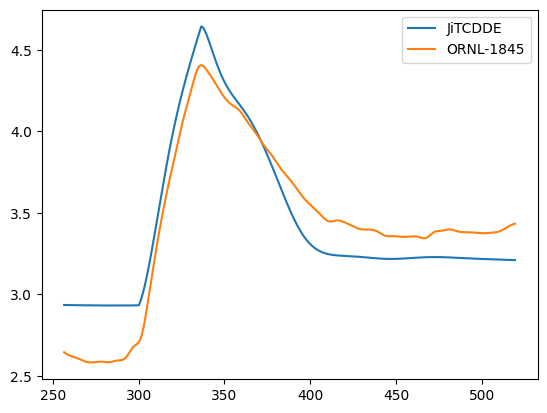

In [16]:
plt.plot(T_insert, [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)],label="JiTCDDE")
plt.plot(T_insert, interpolated_values,label="ORNL-1845")
plt.legend()

(0.0, 1000.0)

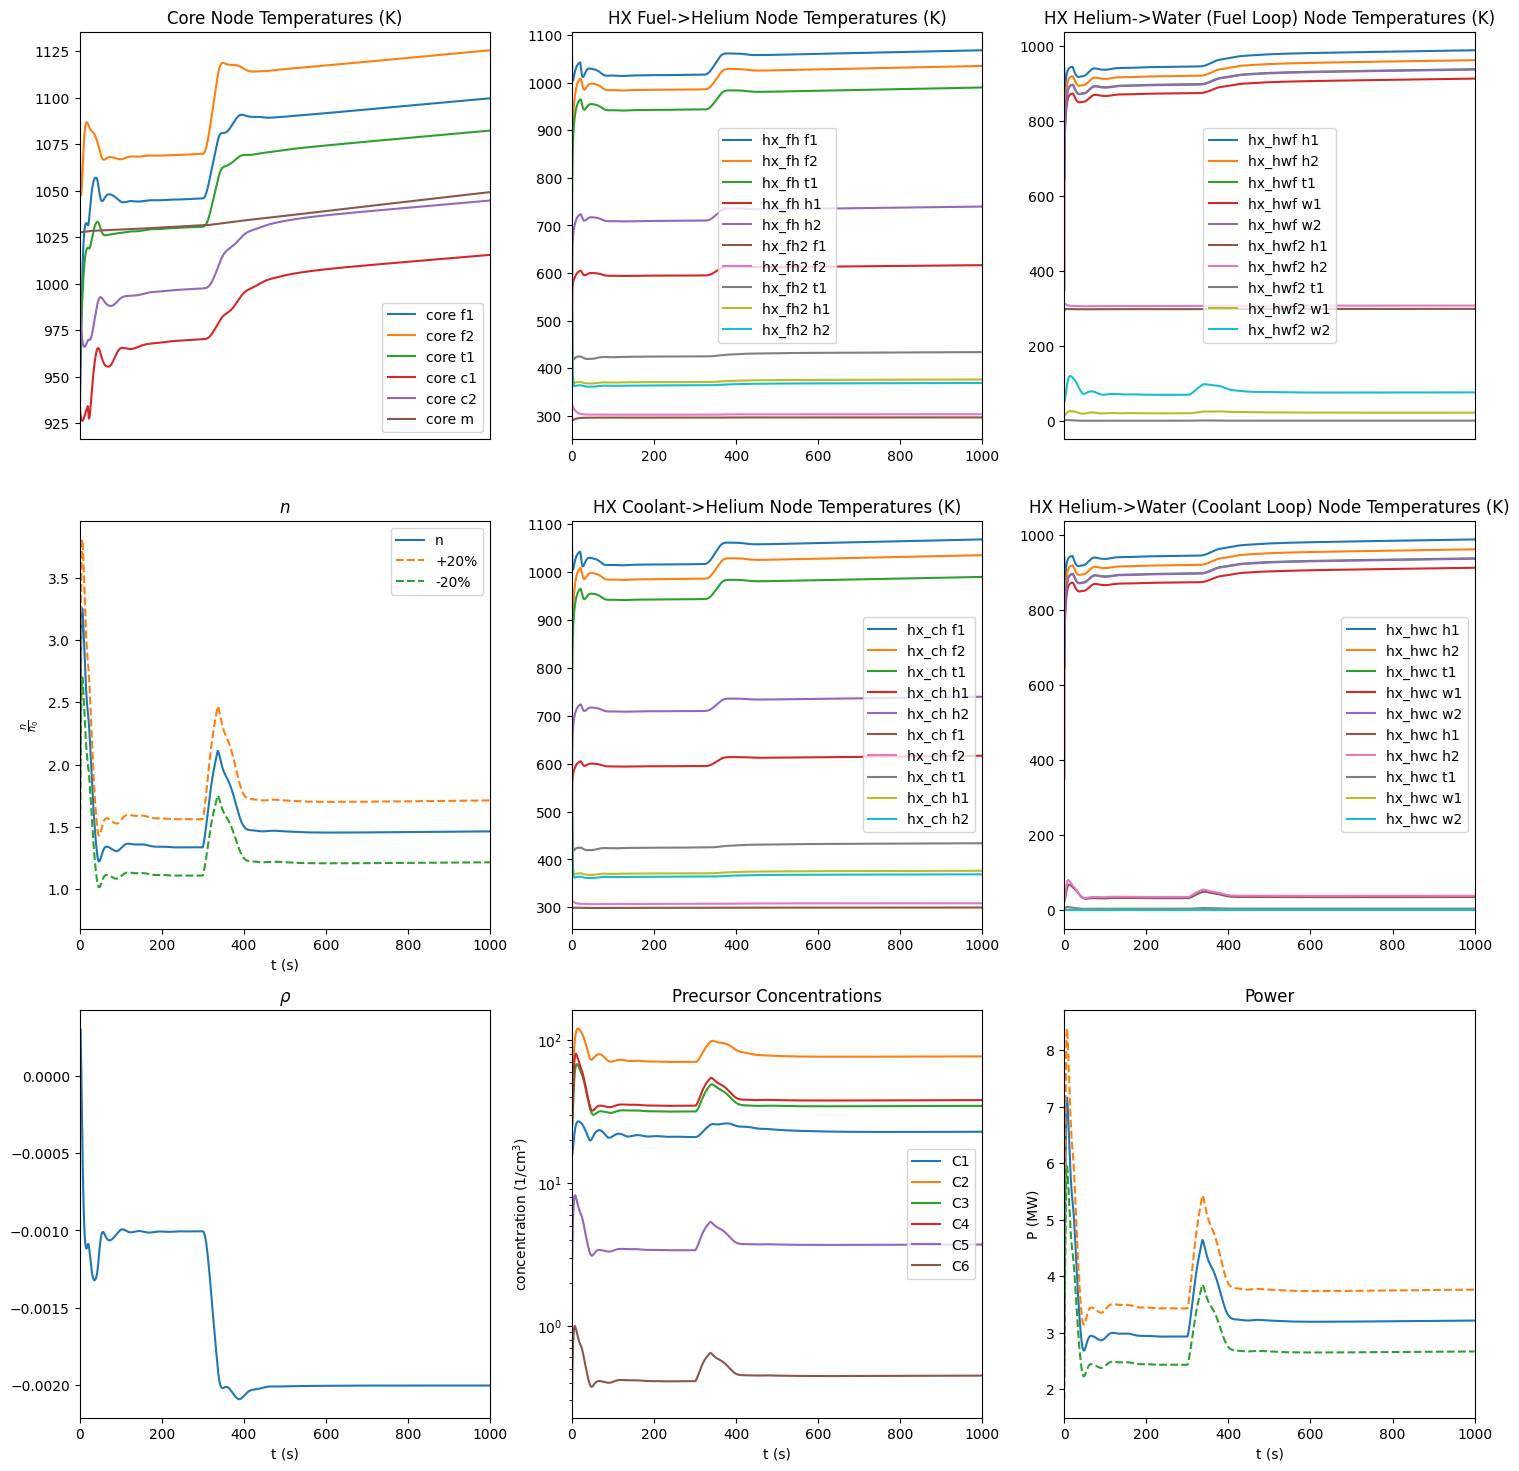

In [17]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 1000
T = np.arange(t_0,t_f,0.01)

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[46] for s in sol_jit],label="n") 
axs[1,0].plot(T,[(1+p_error)*s[46] for s in sol_jit],linestyle="--",label="+20%") 
axs[1,0].plot(T,[(1-p_error)*s[46] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[53] for s in sol_jit],label="rho") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[47] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[48] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[49] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[50] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[51] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[52] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])

axs[2,2].plot(T,[s[46]*P for s in sol_jit],label="Power") 
axs[2,2].plot(T,[(1+p_error)*s[46]*P for s in sol_jit],linestyle="--",label="+20%") 
axs[2,2].plot(T,[(1-p_error)*s[46]*P for s in sol_jit],linestyle="--",label="-20%") 
axs[2,2].set_xlabel("t (s)")
axs[2,2].set_title("Power")
axs[2,2].set_ylabel("P (MW)")
axs[2,2].set_xlim([t_0,t_f])

